In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import sklearn.datasets
import sklearn.decomposition
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
data = pd.read_csv('DrDoS_SSDP_features_removed.csv', skiprows=[i for i in range(1,141550)], skipfooter=141547, engine="python")
data

,Unnamed: 0,Source Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Idle Std,Inbound,Label
0,141549,58319,17,49168.0,2.0,2.0,77.597286,182.852375,38.798643,38.798643,...,1.0,-1.0,-1.0,1.0,20.0,0.000000,0.000000,0.000000,0.0,BENIGN
1,141550,57277,6,117316902.0,29.0,25.0,2218.643591,6500.168425,517.000000,0.000000,...,0.0,23974.0,248.0,13.0,20.0,225719.705119,55213.426719,686169.671291,0.0,BENIGN
2,141551,57648,17,20631.0,2.0,2.0,65.865900,201.512134,32.932950,32.932950,...,1.0,-1.0,-1.0,1.0,30.0,0.000000,0.000000,0.000000,0.0,BENIGN
3,141552,18448,6,98273.0,4.0,2.0,93.179205,135.983898,46.589602,0.000000,...,0.0,168.0,2917.0,1.0,20.0,0.000000,0.000000,0.000000,0.0,BENIGN
4,141553,443,6,118.0,1.0,2.0,0.000000,0.000000,0.000000,0.000000,...,2.0,456.0,256.0,0.0,20.0,0.000000,0.000000,0.000000,1.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,144494,943,17,2.0,2.0,0.0,2928.000000,0.000000,1464.000000,1464.000000,...,0.0,-1.0,-1.0,1.0,373.0,0.000000,0.000000,0.000000,1.0,DrDoS_SSDP
2946,144495,944,17,2.0,2.0,0.0,2944.000000,0.000000,1472.000000,1472.000000,...,0.0,-1.0,-1.0,1.0,373.0,0.000000,0.000000,0.000000,1.0,DrDoS_SSDP
2947,144496,672,17,3.0,2.0,0.0,2944.000000,0.000000,1472.000000,1472.000000,...,0.0,-1.0,-1.0,1.0,373.0,0.000000,0.000000,0.000000,1.0,DrDoS_SSDP
2948,144497,946,17,3.0,2.0,0.0,2944.000000,0.000000,1472.000000,1472.000000,...,0.0,-1.0,-1.0,1.0,373.0,0.000000,0.000000,0.000000,1.0,DrDoS_SSDP


In [3]:
n_features = 2
n_classes = 2
n_samples = 2950

x = StandardScaler().fit_transform(np.array(data.drop(columns=['Label'])))
y = np.array(data['Label'].astype('category').cat.codes.astype(int))

In [4]:
np.random.seed(1967)
x, y = zip(*np.random.permutation(list(zip(x, y))))

pca = sklearn.decomposition.PCA(n_components=n_features)
pca.fit(x)
x = pca.transform(x)

In [5]:
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)
x = 2 * np.pi * (x - x_min) / (x_max - x_min) - np.pi

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)

In [7]:
n_wires = 4

dev0 = qml.device('cirq.simulator', wires=4)
dev1 = qml.device('default.qubit', wires=4)
devs = [dev0, dev1]

In [8]:
def circuit0(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[1, 0, i], wires=i)

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[3, 0])

    for i in range(n_wires):
        qml.Rot(*params[1, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))


def circuit1(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[0, 0, i], wires=i)

    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[1, 3])

    for i in range(n_wires):
        qml.Rot(*params[0, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [9]:
qnodes = qml.QNodeCollection(
    [qml.QNode(circuit0, dev0, interface="torch"),
     qml.QNode(circuit1, dev1, interface="torch")]
)

In [10]:
def decision(softmax):
    return int(torch.argmax(softmax))


def predict_point(params, x_point=None, parallel=True):
    results = qnodes(params, x=x_point, parallel=parallel)
    softmax = torch.nn.functional.softmax(results, dim=1)
    choice = torch.where(softmax == torch.max(softmax))[0][0]
    chosen_softmax = softmax[choice]
    return decision(chosen_softmax), decision(softmax[0]), decision(softmax[1]), int(choice)

In [11]:
def predict(params, x=None, parallel=True):
    predictions_ensemble = []
    predictions_0 = []
    predictions_1 = []
    choices = []

    for i, x_point in enumerate(x):
        if i % 10 == 0 and i > 0:
            print("Completed up to iteration {}".format(i))
        results = predict_point(params, x_point=x_point, parallel=parallel)
        predictions_ensemble.append(results[0])
        predictions_0.append(results[1])
        predictions_1.append(results[2])
        choices.append(results[3])

    return predictions_ensemble, predictions_0, predictions_1, choices

In [12]:
params = np.load("data.npy")
params

array([[[[ 4.68358548, -1.73341509, -0.9620684 ],
         [ 5.1081603 ,  2.258882  , -1.74307764],
         [ 1.81534786, -1.31371396, -1.25811126],
         [ 1.11447681, -6.1681497 , -5.36621205]],

        [[-1.8174755 , -3.46017139,  1.16651341],
         [-2.70042625, -4.51980927,  4.60488828],
         [-1.24587623,  0.22741125, -3.69281809],
         [-1.93254973,  0.59322881, -3.51001639]]],


       [[[ 1.4163029 , -2.34753729, -0.94375486],
         [-1.78997699,  5.99862953,  0.10067329],
         [-3.4458242 ,  2.9359634 , -3.55353059],
         [ 0.46287534, -5.62582181, -4.48131013]],

        [[ 0.61845781,  2.31996118,  0.53836933],
         [-0.36331979, -0.94594516, -4.64491382],
         [-2.26145728, -1.44713938,  3.32104742],
         [ 1.07950869, -5.538754  ,  1.01813982]]]])

In [13]:
%load_ext memory_profiler


In [24]:
%%time

print("Predicting on test dataset")
%memit p_test, p_test_0, p_test_1, choices_test = predict(params, x=x_test)

Predicting on test dataset
Completed up to iteration 10
Completed up to iteration 20
Completed up to iteration 30
Completed up to iteration 40
Completed up to iteration 50
Completed up to iteration 60
Completed up to iteration 70
Completed up to iteration 80
Completed up to iteration 90
Completed up to iteration 100
Completed up to iteration 110
Completed up to iteration 120
Completed up to iteration 130
Completed up to iteration 140
Completed up to iteration 150
Completed up to iteration 160
Completed up to iteration 170
Completed up to iteration 180
Completed up to iteration 190
Completed up to iteration 200
Completed up to iteration 210
Completed up to iteration 220
Completed up to iteration 230
Completed up to iteration 240
Completed up to iteration 250
Completed up to iteration 260
Completed up to iteration 270
Completed up to iteration 280
Completed up to iteration 290
Completed up to iteration 300
Completed up to iteration 310
Completed up to iteration 320
Completed up to iterat

In [25]:
def accuracy(predictions, actuals):
    count = 0

    for i in range(len(predictions)):
        if predictions[i] == actuals[i]:
            count += 1

    accuracy = count / (len(predictions))
    return accuracy

In [26]:
print("Test accuracy (ensemble): {}".format(accuracy(p_test, y_test)))
print("Test accuracy (QPU0):  {}".format(accuracy(p_test_0, y_test)))
print("Test accuracy (QPU1):  {}".format(accuracy(p_test_1, y_test)))

Test accuracy (ensemble): 0.9683615819209039
Test accuracy (QPU0):  0.8463276836158192
Test accuracy (QPU1):  0.6045197740112994


In [27]:
# Combine choices_train and choices_test to simplify analysis
choices = choices_test
print("Choices: {}".format(choices))
print("Choices counts: {}".format(Counter(choices)))

Choices: [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 

In [28]:
predictions =  p_test
choice_vs_prediction = np.array([(choices[i], predictions[i]) for i in range(885)])

In [29]:
choices_vs_prediction_0 = choice_vs_prediction[choice_vs_prediction[:, 0] == 0]
choices_vs_prediction_1 = choice_vs_prediction[choice_vs_prediction[:, 0] == 1]
predictions_0 = choices_vs_prediction_0[:, 1]
predictions_1 = choices_vs_prediction_1[:, 1]


expl = "When QPU{} was chosen by the ensemble, it made the following distribution of " \
       "predictions:\n{}"
print(expl.format("0", Counter(predictions_0)))
print("\n" + expl.format("1", Counter(predictions_1)))
print("\nDistribution of classes in DrDoS_SSDP dataset: {}".format(Counter(y_test)))

When QPU0 was chosen by the ensemble, it made the following distribution of predictions:
Counter({0: 353, 1: 16})

When QPU1 was chosen by the ensemble, it made the following distribution of predictions:
Counter({1: 455, 0: 61})

Distribution of classes in DrDoS_SSDP dataset: Counter({1: 443, 0: 442})


In [30]:
colours_prediction = {"correct": "#00A0B0", "incorrect": "#CC333F"}
markers = ["o", "v"]


def plot_points_prediction(x, y, p, title):
    c = {0: [], 1: [], 2: []}
    x_ = {0: [], 1: [], 2: []}

    for i in range(885):
        x_[y[i]].append(x[i])
        if p[i] == y[i]:
            c[y[i]].append(colours_prediction["correct"])
        else:
            c[y[i]].append(colours_prediction["incorrect"])
    fig = plt.figure(figsize=(5,5), dpi=100) 
    for i in range(n_classes):
        x_class = np.array(x_[i])
        plt.scatter(x_class[:, 0], x_class[:, 1], c=c[i], marker=markers[i])
        
    plt.xlabel("Feature 1", fontsize=11)
    plt.ylabel("Feature 2", fontsize=11)
    plt.title("Predictions from {} model".format(title))
    plt.grid()
    
    ax = plt.gca()
    ax.set_aspect(1)
    c_transparent = "#00000000"

    custom_lines = [
        Patch(
            facecolor=colours_prediction["correct"],
            edgecolor=c_transparent, label="Correct"
        ),
        Patch(
            facecolor=colours_prediction["incorrect"],
            edgecolor=c_transparent, label="Incorrect"
        ),
        Line2D([0], [0], marker=markers[0], color=c_transparent, label="Class 0",
               markerfacecolor="black", markersize=8),
        Line2D([0], [0], marker=markers[1], color=c_transparent, label="Class 1",
               markerfacecolor="black", markersize=8),
    ]

    ax.legend(handles=custom_lines)
    return fig

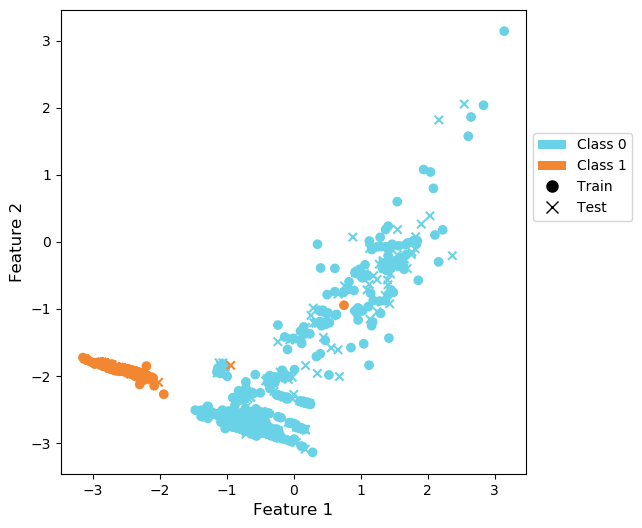

In [31]:
colours = ["#69D2E7", "#F38630"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])
    plt.figure(figsize=(6,10), dpi=100)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        #Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=8),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=8),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train, y_train, x_test, y_test)

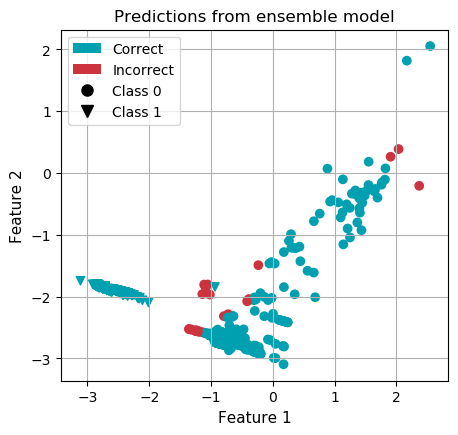

In [32]:
fig = plot_points_prediction(x_test, y_test, p_test, "ensemble")
fig.savefig('PREDICENSEMB.pdf')

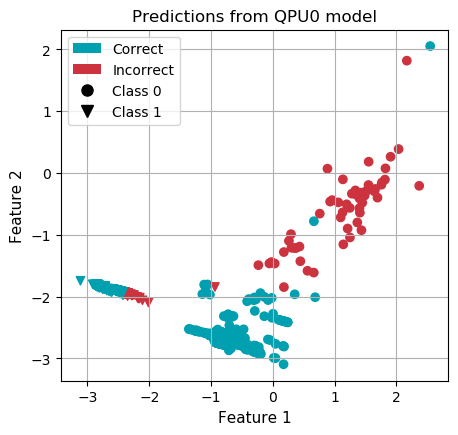

In [33]:
fig = plot_points_prediction(x_test, y_test, p_test_0, "QPU0")
fig.savefig('PREDICQPU0.pdf')

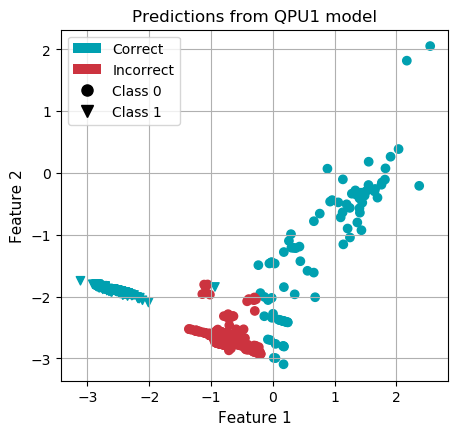

In [34]:

fig = plot_points_prediction(x_test, y_test,p_test_1, "QPU1")
fig.savefig('PREDICQPU1.pdf')

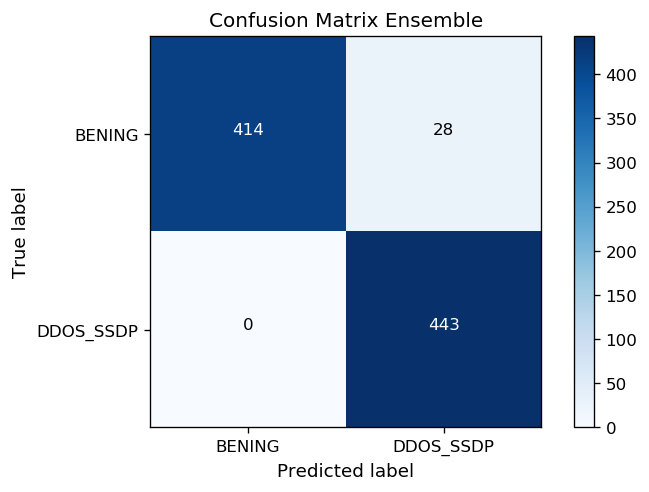

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, p_test)



def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(6, 4), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=11)
    plt.xlabel('Predicted label', fontsize=11)
    plt.show()
    return fig
fig = plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['BENING', 'DDOS_SSDP'],
                      title        = "Confusion Matrix Ensemble")
fig.savefig('CONFUSENSEMBLE.pdf')

In [36]:
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, make_scorer

#Metrics
classification = classification_report(y_test, p_test)
confusion = confusion_matrix(y_test, p_test)
    
    # Accuracy
accuracy = round(accuracy_score(y_test, p_test),5)
    
    # Recall
recall = round(recall_score(y_test, p_test, average='macro')*100,5)
    
    # Precision
precision = round(precision_score(y_test, p_test, average='weighted')*100,5)
    
    # F1
f1 = round(f1_score(y_test, p_test, average='weighted')*100,5)

print(accuracy)
print(recall)
print(precision)
print(f1)
print(1-accuracy)

0.96836
96.83258
97.02424
96.83287
0.03164


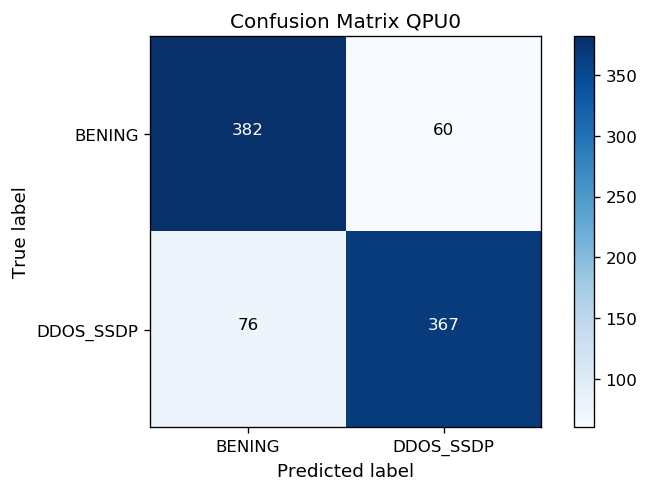

In [37]:
cm = confusion_matrix(y_test, p_test_0)
fig = plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['BENING', 'DDOS_SSDP'],
                      title        = "Confusion Matrix QPU0")
fig.savefig('CONFUSQPU0.pdf')

In [38]:
#Metrics
classification = classification_report(y_test, p_test_0)
confusion = confusion_matrix(y_test, p_test_0)
    
    # Accuracy
accuracy = round(accuracy_score(y_test, p_test_0),5)
    
    # Recall
recall = round(recall_score(y_test, p_test_0, average='macro')*100,5)
    
    # Precision
precision = round(precision_score(y_test, p_test_0, average='weighted')*100,5)
    
    # F1
f1 = round(f1_score(y_test, p_test_0, average='weighted')*100,5)

print(accuracy)
print(recall)
print(precision)
print(f1)
print(1-accuracy)

0.84633
84.63479
84.67873
84.62806
0.15366999999999997


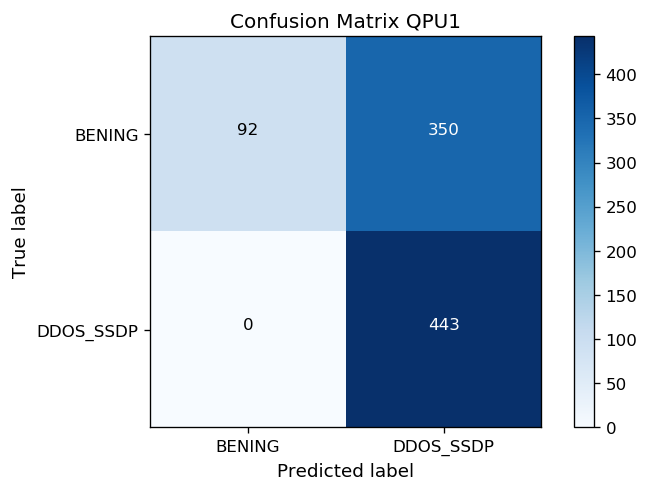

In [39]:
cm = confusion_matrix(y_test, p_test_1)
fig = plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['BENING', 'DDOS_SSDP'],
                      title        = "Confusion Matrix QPU1")
fig.savefig('CONFUSQPU1.pdf')

In [40]:
#Metrics
classification = classification_report(y_test, p_test_1)
confusion = confusion_matrix(y_test, p_test_1)
    
    # Accuracy
accuracy = round(accuracy_score(y_test, p_test_1),5)
    
    # Recall
recall = round(recall_score(y_test, p_test_1, average='macro')*100,5)
    
    # Precision
precision = round(precision_score(y_test, p_test_1, average='weighted')*100,5)
    
    # F1
f1 = round(f1_score(y_test, p_test_1, average='weighted')*100,5)

print(accuracy)
print(recall)
print(precision)
print(f1)
print(1-accuracy)

0.60452
60.40724
77.90697
53.09092
0.39548000000000005


In [41]:
qml.about()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Name: PennyLane
Version: 0.13.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /home/epayares/.local/lib/python3.8/site-packages
Requires: toml, semantic-version, networkx, scipy, appdirs, numpy, autograd
Required-by: PennyLane-qiskit, PennyLane-Cirq
Platform info:           Linux-5.4.0-60-generic-x86_64-with-glibc2.29
Python version:          3.8.5
Numpy version:           1.18.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.13.0)
- default.mixed (PennyLane-0.13.0)
- default.qubit (PennyLane-0.13.0)
- default.qubit.autograd (PennyLane-0.13.0)
- default.qubit.tf (PennyLane-0.13.0)
- default.tensor (PennyLane-0.13.0)
- default.tensor.tf (PennyLane-0.13.0)
- qiskit.aer (PennyLane-qiskit-0.13.0)
- qiskit.basicaer (PennyLane-qiskit-0.13.0)
- qiskit.ibmq (PennyLane-qiskit-0.13.0)
- cirq.mixedsimulator (Penn